In [1]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch


In [2]:
# Dataloader for BSDS500 dataset
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class BSDS500(Dataset):
    def __init__(self, image_dir, edge_dir, transform=None, edge_transform=None):
        """
        Custom dataloader for BSDS500 edge detection dataset using JPG ground truth.

        Args:
            image_dir (str): Path to image directory (train, val, test).
            edge_dir (str): Path to corresponding edge ground truth directory.
            transform (callable, optional): Transformations for images.
            edge_transform (callable, optional): Transformations for edge maps.
        """
        self.image_dir = image_dir
        self.edge_dir = edge_dir
        self.transform = transform
        self.edge_transform = edge_transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load Image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Load Ground Truth Edge Image
        edge_path = os.path.join(self.edge_dir, img_name)
        edge_image = Image.open(edge_path).convert('L')

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.edge_transform:
            edge_image = self.edge_transform(edge_image)

        return image, edge_image

# Separate transforms
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

edge_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create Dataloaders
train_dataset = BSDS500(image_dir='archive/images/train', edge_dir='archive/ground_truth_boundaries/train',
                         transform=image_transform, edge_transform=edge_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = BSDS500(image_dir='archive/images/val', edge_dir='archive/ground_truth_boundaries/val',
                       transform=image_transform, edge_transform=edge_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)


In [3]:
# CNN architecture

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

In [4]:
import torch.nn.functional as F

class BalancedBCELoss(nn.Module):
    def __init__(self):
        super(BalancedBCELoss, self).__init__()

    def forward(self, pred, target):
        """
        Compute class-balanced binary cross-entropy loss using HED paper's formula.

        Args:
            pred (torch.Tensor): Predicted probabilities (values between 0 and 1).
            target (torch.Tensor): Ground truth edge maps (binary: 0 or 1).

        Returns:
            torch.Tensor: Class-balanced BCE loss.
        """
        # Ensure predictions are in range for numerical stability
        pred = torch.clamp(pred, 1e-6, 1 - 1e-6)
        
        # Calculate class counts
        pos_count = torch.sum(target)
        neg_count = target.numel() - pos_count
        
        # Compute β using the HED paper formula
        beta = neg_count / (pos_count + neg_count + 1e-6)

        # Compute class-balanced BCE loss using PyTorch's BCE function
        weights = beta * target + (1 - beta) * (1 - target)
        loss = F.binary_cross_entropy(pred, target, weight=weights)

        return loss

In [5]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device='cuda'):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        epoch_loss = 0
        for images, edges in train_loader:
            images, edges = images.to(device), edges.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, edges)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, edges in val_loader:
                images, edges = images.to(device), edges.to(device)

                outputs = model(images)
                loss = criterion(outputs, edges)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss}, Validation Loss: {val_loss}')
    
    return train_losses, val_losses


In [6]:
import torch.optim as optim
# Initialize model, criterion, and optimizer
model = CNN()
criterion = BalancedBCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and Validate
train_losses, val_losses = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)


Epoch [1/100], Train Loss: 0.022003367113379333, Validation Loss: 0.019822651892900466
Epoch [2/100], Train Loss: 0.01877890169047392, Validation Loss: 0.018060890324413777
Epoch [3/100], Train Loss: 0.017826779888799556, Validation Loss: 0.017436018399894237
Epoch [4/100], Train Loss: 0.017646990071695585, Validation Loss: 0.017342021241784095
Epoch [5/100], Train Loss: 0.017465989821805403, Validation Loss: 0.01722584933042526
Epoch [6/100], Train Loss: 0.017434819816396788, Validation Loss: 0.01719141524285078
Epoch [7/100], Train Loss: 0.0173275490792898, Validation Loss: 0.017166137769818304
Epoch [8/100], Train Loss: 0.017421091047043983, Validation Loss: 0.017149045765399933
Epoch [9/100], Train Loss: 0.01720466113720949, Validation Loss: 0.017124631591141224
Epoch [10/100], Train Loss: 0.017166490809848674, Validation Loss: 0.01713039856404066
Epoch [11/100], Train Loss: 0.01715209070019997, Validation Loss: 0.017105619348585607
Epoch [12/100], Train Loss: 0.017285828550274555,

In [119]:
test_dataset = BSDS500(image_dir='archive/images/test', edge_dir='archive/ground_truth_boundaries/test',
                        transform=image_transform, edge_transform=edge_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True) 

In [120]:
def plot_results(model, dataloader, threshold=0.25, device='cpu', num_batches=2):
    model.eval()
    batch_count = 0
    
    with torch.no_grad():
        for images, edges in dataloader:
            images = images.to(device)
            edges = edges.unsqueeze(1).to(device)

            outputs = model(images)
            predictions = (outputs > threshold).float()

            for i in range(len(images)):
                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                plt.title("Input Image")

                plt.subplot(1, 3, 2)
                plt.imshow(edges[i].cpu().squeeze(), cmap='gray')
                plt.title("Ground Truth")

                plt.subplot(1, 3, 3)
                plt.imshow(predictions[i].cpu().squeeze(), cmap='gray')
                plt.title("Predicted Edges")

                plt.show()
                
            batch_count += 1
            if batch_count >= num_batches:
                break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


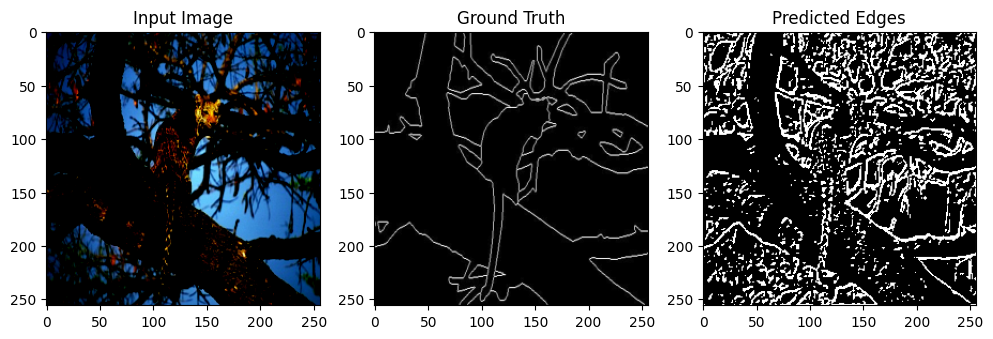

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.9764706].


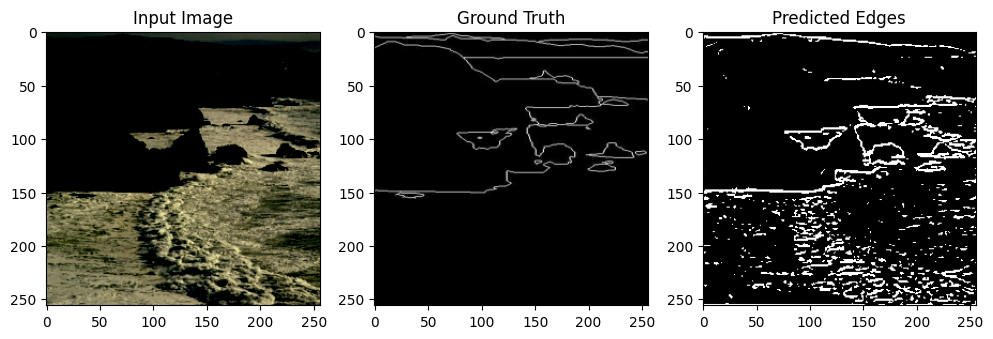

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].


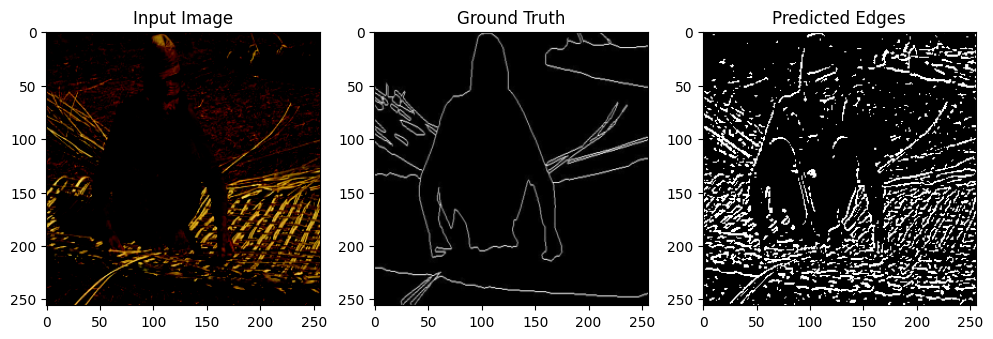

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


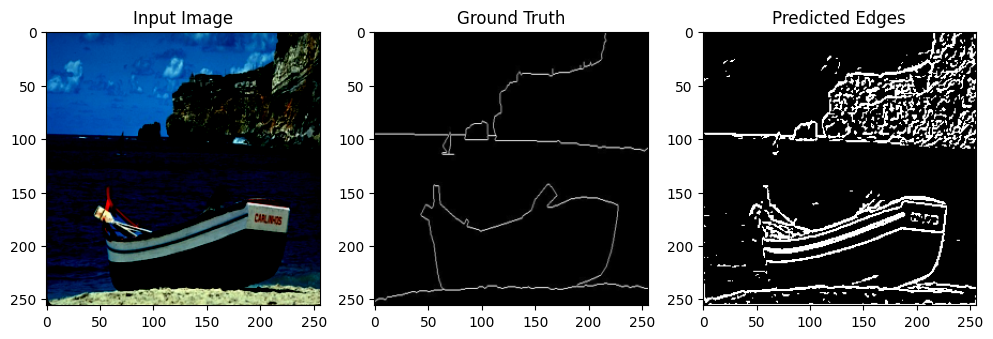

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


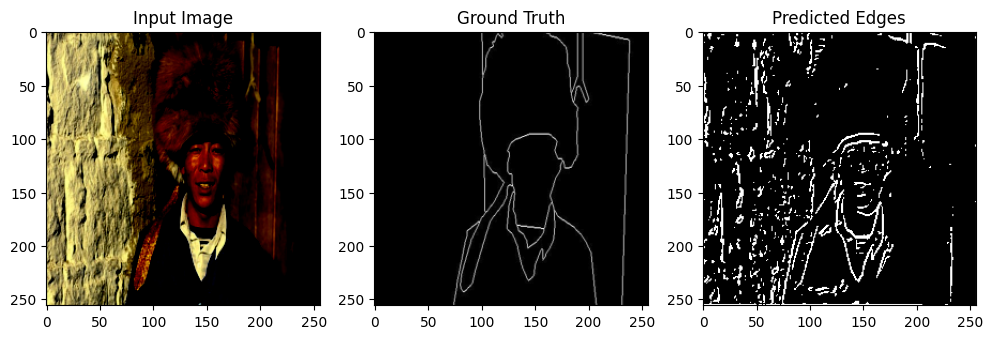

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


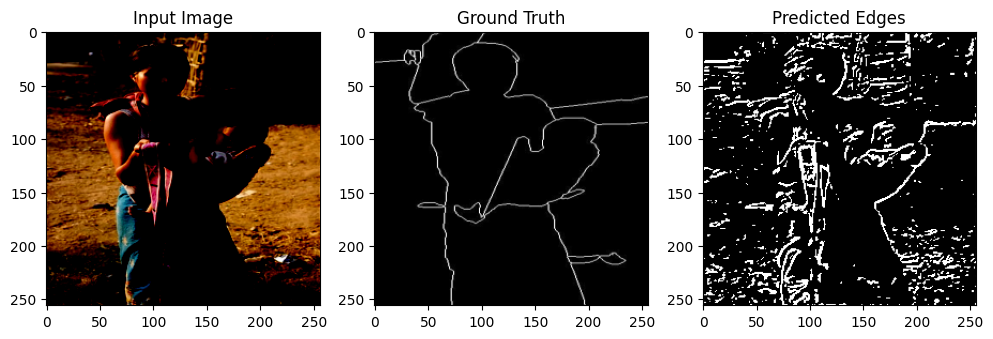

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


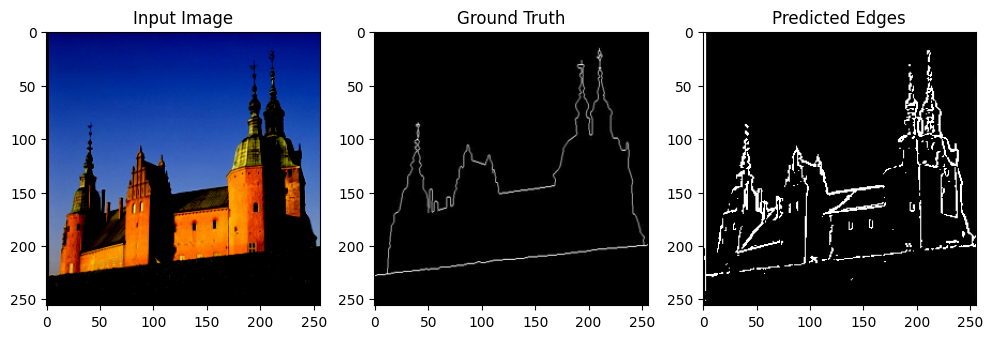

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..0.96862745].


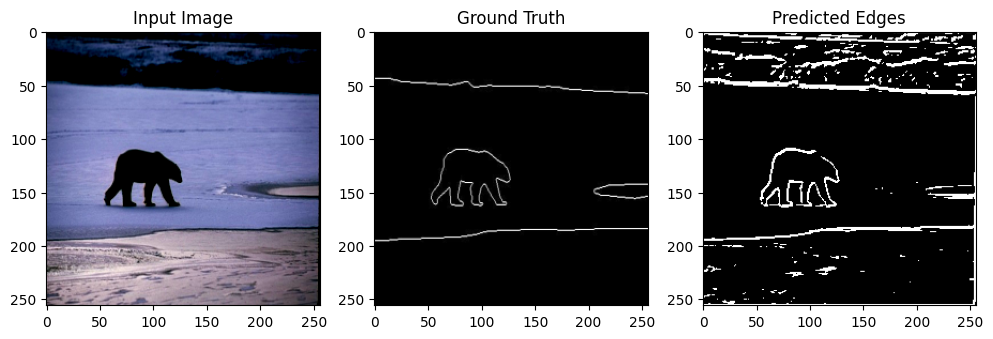

In [152]:
plot_results(model, test_loader, threshold=0.28, device='cpu', num_batches=2)